In [60]:
import numpy as np
from scipy import interpolate
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# **Import Data**

In [2]:
data1, data2 = np.loadtxt('sicr.nk') , np.loadtxt('sio2.nk')   #import des indice de réfraction,longueur d'onde etc 
#data3 = np.loadtxt('ambiant.txt')  # si pas l'air

x1, y1, z1 = data1 [:,0], data1 [:,1], data1 [:,2]  #substrat
x2, y2, z2 = data2 [:,0], data2 [:,1], data2 [:,2]  #film
#x3, y3, z3 = data3 [:,0], data3 [:,1], data3 [:,2]  #ambiant si pas air

# **Fonctions utilisées**

In [61]:
def n_air(long_onde):   # ref : Ulf’s cyber attic - thin film toolbox
    lambdas = long_onde
    pres = 101325
    temp = 20
    relh = 0
    A = 8342.54
    B = 2406147.0
    C = 15998.0
    D = 96095.43
    E = 0.601
    F = 0.00972
    G = 0.003661
    s2 = (1 / lambdas)**2
    ns = 1.0 + 1.0e-8 * (A + B/(130.0 - s2) + C/(38.9 - s2))
    X = (1.0 + 1.0e-8 * pres * (E - F * temp)) / (1.0 + G * temp)
    ntp = 1.0 + pres * (ns - 1.0) * X / D
    pv = 0.01 * relh * water_svp(temp)
    ri = ntp - (292.75e-10/(temp + 273.15)) * (3.7345 - 0.0401 * s2) * pv
    return ri


def water_svp(temp):  # ref : Ulf’s cyber attic - thin film toolbox
    T = temp + 273.15
    K1 = 1.16705214528E+03
    K2 = -7.24213167032E+05
    K3 = -1.70738469401E+01
    K4 = 1.20208247025E+04
    K5 = -3.23255503223E+06
    K6 = 1.49151086135E+01
    K7 = -4.82326573616E+03
    K8 = 4.05113405421E+05
    K9 = -2.38555575678E-01
    K10 = 6.50175348448E+02
    A1 = -13.928169
    A2 = 34.7078238
    A3 = 661.657
    if temp > 0:
        omega = T + K9 / (T - K10)
        A = omega * (omega + K1) + K2
        B = omega * (omega * K3 + K4) + K5
        C = omega * (omega * K6 + K7) + K8
        X = np.sqrt(B**2 - 4 * A * C) - B
        svp = 1.0e6 * (2 * C / X)**4
    else:
        theta = T / 273.16
        Y = A1 * (1 - theta**-1.5) + A2 * (1 - theta**-1.25)
        svp = A3 * np.exp(Y)
    return svp


def gen2D(N, rL, h, clx):  # génération de la surface à 2D
    X, Y = np.meshgrid(x, y)
    np.random.seed(666)
    Z = h * np.random.randn(N, N)
    F = np.exp(-((X**2 + Y**2)/((clx**2)/2)))
    f = 2 / np.sqrt(np.pi) * rL/N/clx * \
        np.fft.ifft2((np.fft.fft2(Z)*np.fft.fft2(F)))
    return f


# calcul de réfléctivité (modèle substrat/film/ambiant)
def reflectivity(long_onde, ind_refracrsub, ind_refracrfilm, ind_refracrambiant, dfilm):
    x = long_onde  # in micrometers
    n0 = ind_refracrambiant
    n1 = ind_refracrfilm
    n2 = ind_refracrsub
    thick = dfilm
    r12 = (n2-n1)/(n2+n1)
    r01 = (n1-n0)/(n1+n0)
    beta = 2*np.pi/x*thick*n1
    r = (r01+r12*np.exp(-2j*beta))/(1+r01*r12*np.exp(-2j*beta))
    rr = r*r.conjugate()
    return rr


def reflectivity2(long_onde, dfilm):  # Même fonction mais modifiée en array pour le fit
    x = np.array(long_onde)  # in micrometers
    n0 = np.array(ind_refracair)
    n1 = np.array(ind_refracrfilm)
    n2 = np.array(ind_refracrsub)
    thick = dfilm
    r12 = (n2-n1)/(n2+n1)
    r01 = (n1-n0)/(n1+n0)
    beta = 2*np.pi/x*thick*n1
    r = (r01+r12*np.exp(-2j*beta))/(1+r01*r12*np.exp(-2j*beta))
    rr = np.real(r*r.conjugate())
    return rr


def reflectivityEMA(long_onde, dfilm, dema):
    x = np.array(long_onde)  # in micrometers
    n0 = np.array(ind_refracair)
    n1 = np.array(ind_ema)
    n2 = np.array(ind_refracrfilm)
    n3 = np.array(ind_refracrsub)
    thickfilm = dfilm
    thickema = dema
    r12 = (n2-n1)/(n2+n1)
    r23 = (n3-n2)/(n3+n2)
    r01 = (n1-n0)/(n1+n0)
    beta1 = 2*np.pi/x*thickema*n1
    beta2 = 2*np.pi/x*thickfilm*n2
    r123 = (r12 + r23*np.exp(-2j*beta2))/(1 + r12*r23*np.exp(-2j*beta2))
    r = ((r01 + r123*np.exp(-2j*beta1)))/(1 + r01*r123*np.exp(-2j*beta1))
    rr = np.real(r*r.conjugate())
    return rr


def ncalema(nambiant, nfilm, fv):
    n0 = np.array(nambiant)
    n1 = np.array(nfilm)
    gamma = (1 - fv)*(n1**2 - 2*n0**2) + fv * ((n0**2) - 2*(n1**2))
    p1 = (gamma**2 + 8*(n0**2 * n1**2))**0.5
    n = (p1-gamma) ** 0.5
    nn = n/2
    return nn

# **Interpolation des indices de réfractions**

In [62]:
f1 = interpolate.interp1d(x1, y1)
f1i = interpolate.interp1d(x1, z1)
f2 = interpolate.interp1d(x2, y2)
f2i = interpolate.interp1d(x2, z2)  # interpolation (que réel)
# f3 = interpolate.interp1d(x3, y3) #si pas air

In [63]:
long_onde = np.linspace(0.4, 1.0, 61)  # spectre de longueur d'onde

ind_refracrsub = []
ind_refracrfilm = []
ind_refracair = []

for i in range(len(long_onde)):  # obtenir les indices de réfractions
    ind_refracrsub.append(complex(f1(long_onde[i]), f1i(long_onde[i])))
    ind_refracrfilm.append(complex(f2(long_onde[i]), f2i(long_onde[i])))
    ind_refracair.append(n_air(long_onde[i]))


# nombre = len(long_onde)


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


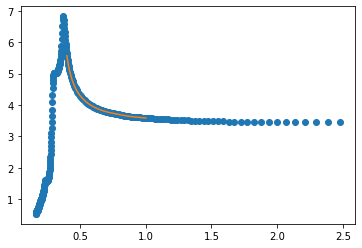

In [64]:
plt.plot(x1, y1, 'o', long_onde, ind_refracrsub, '-')
plt.show()

# **Paramètre + génération d'une surface**

In [29]:
N = 128  # nombre de points
rL = 128                # longueur de la surface
h = 0.025               # rugosité (rms)
clx = 25                # longueur de corrélation
cly = 64
x = np.linspace(-rL/2, rL/2, N)  # coordonnée
y = np.linspace(-rL/2, rL/2, N)

In [30]:
surf = np.real(gen2D(N, rL, h, clx))
thickness = 0.3
surfall = surf + np.ones((N, N))*thickness  # épaisseur moyenne + fluctuation

In [31]:
surfalllist = []  # transformation en liste pour l'histogramme
for list_ep in surfall:
    for ep in list_ep:
        surfalllist.append(ep)

Text(0.5, 0, 'épaisseur(µm)')

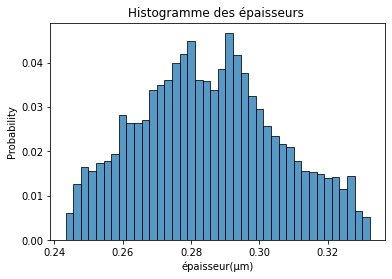

In [32]:
histo = sns.histplot(surfalllist, stat="probability")
histo.set_title('Histogramme des épaisseurs ')
histo.set_xlabel("épaisseur(µm)")

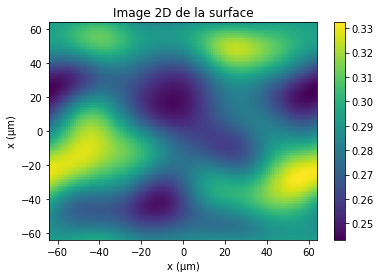

In [35]:
plt.pcolor(x, y, surfall)
plt.colorbar()
plt.xlabel('x (µm)')
plt.ylabel('x (µm)')
plt.title('Image 2D de la surface')
plt.show()

# **Analyse inversion en fonction de la longueur de corrélation et de la rugosité (rms)**





In [66]:
N = 50  # nombre de points
rL = 50                  # longueur de la surface
h = np.linspace(0.00025/2, 0.025, 32)                # rugosité (rms)
clx = np.linspace(1, 16, 32)                         # longueur de corrélation
cly = 30
x = np.linspace(-rL/2, rL/2, N)  # coordonnée
y = np.linspace(-rL/2, rL/2, N)

In [67]:
voulue = thickness + h  # aide au fit
thickness = 0.3
RRT = 0
Epp = []
for i, corel_x in tqdm(enumerate(clx)):
    Epp.append([])
    for j, rugosity in enumerate(h):
        voulue = thickness + rugosity
        Epp[i].append([])
        # génération de la surface
        surf = np.real(gen2D(N, rL, rugosity, corel_x))
        surfall = surf + np.ones((N, N))*thickness
        R = []
        for k, lambda_ in enumerate(long_onde):
            RRT = 0
            RRT = reflectivity(
                lambda_, ind_refracrsub[k], ind_refracrfilm[k], ind_refracair[k], surfall)
            R.append(np.real(np.mean(RRT)))
        Epp[i][j] = float(optimize.curve_fit(reflectivity2, long_onde, R, p0=voulue, method='lm')[0])  # création de la matrice pour le plot          

32it [00:31,  1.01it/s]


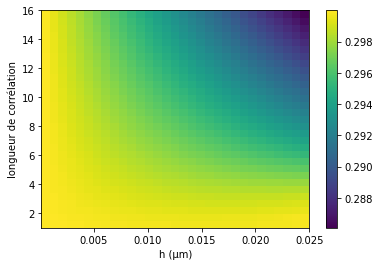

In [68]:
plt.pcolor(h,clx, Epp)
plt.colorbar()
plt.ylabel('longueur de corrélation')
plt.xlabel('h (µm)')
plt.show()

# **Analyse inversion en fonction de la longueur de corrélation et de la rugosité avec ajout de la théories des milieux effectifs (EMA)**

In [69]:
N = 64  # nombre de points
rL = 64             # longueur de la surface
h = np.linspace(0.00025/2, 0.025, 32)                # rugosité (rms)
clx = np.linspace(1, 64, 32)                       # longueur de corrélation
cly = 30
x = np.linspace(-rL/2, rL/2, N)  # coordonnée
y = np.linspace(-rL/2, rL/2, N)

In [70]:
long_onde = np.linspace(0.4, 1.0, 61)  # spectre de longueur d'onde

ind_refracrsub = []
ind_refracrfilm = []
ind_refracair = []


for lambda_ in (long_onde):  # obtenir les indices de réfractions
    ind_refracrsub.append(complex(f1(lambda_), f1i(lambda_)))
    ind_refracrfilm.append(complex(f2(lambda_), f2i(lambda_)))
    ind_refracair.append(n_air(lambda_))

ind_ema = ncalema(ind_refracair, ind_refracrfilm, 0.5)

thickness = 0.3
Epp1 = []
Epp2 = []
for i, corel_lenght in tqdm(enumerate(clx)):
    Epp1.append([])
    Epp2.append([])
    for j, rugosity in enumerate(h):
        voulue = thickness + rugosity
        voulue3 = 0.9*voulue
        voulue2 = 0.1 * voulue
        Epp1[i].append([])
        Epp2[i].append([])
        # génération de la surface
        surf = np.real(gen2D(N, rL, rugosity, corel_lenght))
        surfall = surf + np.ones((N, N))*thickness
        R = []
        for k, lambda_2 in enumerate(long_onde):
            RRT = reflectivity(
                lambda_2, ind_refracrsub[k], ind_refracrfilm[k], ind_refracair[k], surfall)
            R.append(np.real(np.mean(RRT)))
        result = optimize.curve_fit(
            reflectivityEMA, long_onde, R, p0=(voulue3, voulue2), method='lm')
        Epp1[i][j] = result[0][0]
        Epp2[i][j] = result[0][1]  # création de la matrice pour le plot

32it [00:43,  1.35s/it]


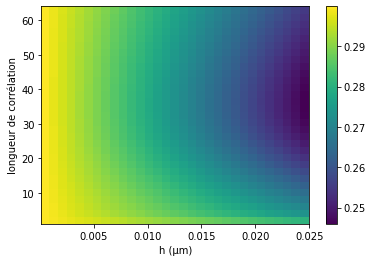

In [71]:
plt.pcolor(h, clx, Epp1)
plt.colorbar()
plt.ylabel('longueur de corrélation')
plt.xlabel('h (µm)')
plt.show()

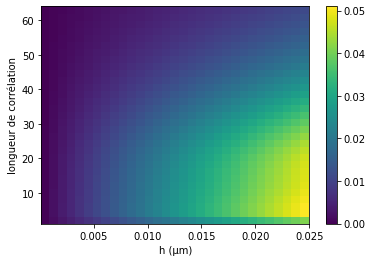

In [72]:
plt.pcolor(h, clx, Epp2)
plt.colorbar()
plt.ylabel('longueur de corrélation')
plt.xlabel('h (µm)')
plt.show()